In [1]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
import re
import os

In [2]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

## Data Cleaning

In [3]:
pd.read_csv("/project/ds5559/group2_triage/ds5110_final_project/data_dictionary.csv")

,Group,1: Local ED / 2: Regional ED
0,Sex,1: Female / 2: Male
1,Age,Age (Years)
2,Patients number per hour,Patients number/hous
3,Arrival mode,1: Walking / 2: 119 use / 3: Private car / 4: ...
4,Injury,1: Non-injury / 2: Injury
5,Mental,1: Alert / 2: Verval response / 3: Pain respon...
6,Pain,1: Pain / 2: Non-pain
7,NRS_pain,Numeric rating scales of pain
8,SBP,Systolid blood pressure
9,DBP,Diastolic blood pressure


In [4]:
encounters = sc.textFile("/project/ds5559/group2_triage/ds5110_final_project/triage_data.csv")
encounters.take(5)

['Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,SBP,DBP,HR,RR,BT,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage',
 '2,2,71,3,3,2,right ocular pain,1,1,2,160,100,84,18,36.6,100,2,Corneal abrasion,1,4,2,86,5.00,1',
 '1,1,56,12,3,2,right forearm burn,1,1,2,137,75,60,20,36.5,,4,"Burn of hand, firts degree dorsum",1,5,4,64,3.95,1',
 '2,1,68,8,2,2,"arm pain, Lt",1,1,2,130,80,102,20,36.6,98,4,"Fracture of surgical neck of humerus, closed",2,5,4,862,1.00,1',
 '1,2,71,8,1,1,ascites tapping,1,1,3,139,94,88,20,36.5,,4,Alcoholic liver cirrhosis with ascites,1,5,6,108,9.83,1']

In [5]:
spark.read.csv("/project/ds5559/group2_triage/ds5110_final_project/triage_data.csv", header = True).show(10)

+-----+---+---+------------------------+------------+------+--------------------+------+----+--------+---+---+---+---+----+----------+-------+--------------------+-----------+-----------+-----------+------------------+-----------------+---------+
|Group|Sex|Age|Patients number per hour|Arrival mode|Injury|      Chief_complain|Mental|Pain|NRS_pain|SBP|DBP| HR| RR|  BT|Saturation|KTAS_RN|     Diagnosis in ED|Disposition|KTAS_expert|Error_group|Length of stay_min|KTAS duration_min|mistriage|
+-----+---+---+------------------------+------------+------+--------------------+------+----+--------+---+---+---+---+----+----------+-------+--------------------+-----------+-----------+-----------+------------------+-----------------+---------+
|    2|  2| 71|                       3|           3|     2|   right ocular pain|     1|   1|       2|160|100| 84| 18|36.6|       100|      2|    Corneal abrasion|          1|          4|          2|                86|             5.00|        1|
|    1|  1| 

In [6]:
header = encounters.first()
encounters_no_header = encounters.filter(lambda x: header != x)

In [7]:
header

'Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,SBP,DBP,HR,RR,BT,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage'

In [8]:
encounters_no_header.take(5)

['2,2,71,3,3,2,right ocular pain,1,1,2,160,100,84,18,36.6,100,2,Corneal abrasion,1,4,2,86,5.00,1',
 '1,1,56,12,3,2,right forearm burn,1,1,2,137,75,60,20,36.5,,4,"Burn of hand, firts degree dorsum",1,5,4,64,3.95,1',
 '2,1,68,8,2,2,"arm pain, Lt",1,1,2,130,80,102,20,36.6,98,4,"Fracture of surgical neck of humerus, closed",2,5,4,862,1.00,1',
 '1,2,71,8,1,1,ascites tapping,1,1,3,139,94,88,20,36.5,,4,Alcoholic liver cirrhosis with ascites,1,5,6,108,9.83,1',
 '1,2,58,4,3,1,"distension, abd",1,1,3,91,67,93,18,36.5,,4,Ascites,1,5,8,109,6.60,1']

In [9]:
index_cc = header.split(",").index("Chief_complain")
index_cc

6

In [10]:
encounters_lower = encounters_no_header.map(lambda x: x.lower())
encounters_lower.take(5)

['2,2,71,3,3,2,right ocular pain,1,1,2,160,100,84,18,36.6,100,2,corneal abrasion,1,4,2,86,5.00,1',
 '1,1,56,12,3,2,right forearm burn,1,1,2,137,75,60,20,36.5,,4,"burn of hand, firts degree dorsum",1,5,4,64,3.95,1',
 '2,1,68,8,2,2,"arm pain, lt",1,1,2,130,80,102,20,36.6,98,4,"fracture of surgical neck of humerus, closed",2,5,4,862,1.00,1',
 '1,2,71,8,1,1,ascites tapping,1,1,3,139,94,88,20,36.5,,4,alcoholic liver cirrhosis with ascites,1,5,6,108,9.83,1',
 '1,2,58,4,3,1,"distension, abd",1,1,3,91,67,93,18,36.5,,4,ascites,1,5,8,109,6.60,1']

In [11]:
encounters_lower.take(28)

['2,2,71,3,3,2,right ocular pain,1,1,2,160,100,84,18,36.6,100,2,corneal abrasion,1,4,2,86,5.00,1',
 '1,1,56,12,3,2,right forearm burn,1,1,2,137,75,60,20,36.5,,4,"burn of hand, firts degree dorsum",1,5,4,64,3.95,1',
 '2,1,68,8,2,2,"arm pain, lt",1,1,2,130,80,102,20,36.6,98,4,"fracture of surgical neck of humerus, closed",2,5,4,862,1.00,1',
 '1,2,71,8,1,1,ascites tapping,1,1,3,139,94,88,20,36.5,,4,alcoholic liver cirrhosis with ascites,1,5,6,108,9.83,1',
 '1,2,58,4,3,1,"distension, abd",1,1,3,91,67,93,18,36.5,,4,ascites,1,5,8,109,6.60,1',
 '2,1,54,6,4,1,fever,1,1,3,140,90,94,20,38.1,98,3,"fever, unspecified",2,4,1,9246,2.00,1',
 '2,2,49,11,3,1,with chest discomfort,1,1,3,110,70,70,20,36.2,98,2,"angina pectoris, unspecified",1,3,2,400,3.00,1',
 '1,2,78,14,3,1,"pain, chest",1,1,3,169,86,80,20,36,,2,acute coronary syndrome,1,3,2,247,10.23,1',
 '1,2,32,10,3,1,lbp - low back pain,1,1,3,140,75,91,20,36.6,,4,herniated disc disease of lumbar spine with radiculopathy,1,5,4,59,3.23,1',
 '2,1,38,6,

In [12]:
encounters_comma = encounters_lower.map(lambda row: re.sub('(".*)(,\s*)(.*")', r'\1;\3', row))
encounters_comma.take(28)

['2,2,71,3,3,2,right ocular pain,1,1,2,160,100,84,18,36.6,100,2,corneal abrasion,1,4,2,86,5.00,1',
 '1,1,56,12,3,2,right forearm burn,1,1,2,137,75,60,20,36.5,,4,"burn of hand;firts degree dorsum",1,5,4,64,3.95,1',
 '2,1,68,8,2,2,"arm pain, lt",1,1,2,130,80,102,20,36.6,98,4,"fracture of surgical neck of humerus;closed",2,5,4,862,1.00,1',
 '1,2,71,8,1,1,ascites tapping,1,1,3,139,94,88,20,36.5,,4,alcoholic liver cirrhosis with ascites,1,5,6,108,9.83,1',
 '1,2,58,4,3,1,"distension;abd",1,1,3,91,67,93,18,36.5,,4,ascites,1,5,8,109,6.60,1',
 '2,1,54,6,4,1,fever,1,1,3,140,90,94,20,38.1,98,3,"fever;unspecified",2,4,1,9246,2.00,1',
 '2,2,49,11,3,1,with chest discomfort,1,1,3,110,70,70,20,36.2,98,2,"angina pectoris;unspecified",1,3,2,400,3.00,1',
 '1,2,78,14,3,1,"pain;chest",1,1,3,169,86,80,20,36,,2,acute coronary syndrome,1,3,2,247,10.23,1',
 '1,2,32,10,3,1,lbp - low back pain,1,1,3,140,75,91,20,36.6,,4,herniated disc disease of lumbar spine with radiculopathy,1,5,4,59,3.23,1',
 '2,1,38,6,3,1,"e

In [13]:
encounters_english = encounters_comma.map(lambda row: re.sub("[^a-zA-Z0-9,;\s]", "", row))
encounters_english.take(25)

['2,2,71,3,3,2,right ocular pain,1,1,2,160,100,84,18,366,100,2,corneal abrasion,1,4,2,86,500,1',
 '1,1,56,12,3,2,right forearm burn,1,1,2,137,75,60,20,365,,4,burn of hand;firts degree dorsum,1,5,4,64,395,1',
 '2,1,68,8,2,2,arm pain, lt,1,1,2,130,80,102,20,366,98,4,fracture of surgical neck of humerus;closed,2,5,4,862,100,1',
 '1,2,71,8,1,1,ascites tapping,1,1,3,139,94,88,20,365,,4,alcoholic liver cirrhosis with ascites,1,5,6,108,983,1',
 '1,2,58,4,3,1,distension;abd,1,1,3,91,67,93,18,365,,4,ascites,1,5,8,109,660,1',
 '2,1,54,6,4,1,fever,1,1,3,140,90,94,20,381,98,3,fever;unspecified,2,4,1,9246,200,1',
 '2,2,49,11,3,1,with chest discomfort,1,1,3,110,70,70,20,362,98,2,angina pectoris;unspecified,1,3,2,400,300,1',
 '1,2,78,14,3,1,pain;chest,1,1,3,169,86,80,20,36,,2,acute coronary syndrome,1,3,2,247,1023,1',
 '1,2,32,10,3,1,lbp  low back pain,1,1,3,140,75,91,20,366,,4,herniated disc disease of lumbar spine with radiculopathy,1,5,4,59,323,1',
 '2,1,38,6,3,1,eczema;eyelid,1,1,3,130,80,80,20,3

In [14]:
len(encounters_english.first().split(","))

24

In [15]:
encounters_split = encounters_english.map(lambda x: re.sub("  ", "-", x)) \
                                     .map(lambda x: re.sub(", ,", ",,", x)) \
                                     .map(lambda x: re.sub(", ", ";", x)) \
                                     .map(lambda x: x.rstrip()) \
                                     .map(lambda x: x.split(","))
encounters_split.take(2)

[['2',
  '2',
  '71',
  '3',
  '3',
  '2',
  'right ocular pain',
  '1',
  '1',
  '2',
  '160',
  '100',
  '84',
  '18',
  '366',
  '100',
  '2',
  'corneal abrasion',
  '1',
  '4',
  '2',
  '86',
  '500',
  '1'],
 ['1',
  '1',
  '56',
  '12',
  '3',
  '2',
  'right forearm burn',
  '1',
  '1',
  '2',
  '137',
  '75',
  '60',
  '20',
  '365',
  '',
  '4',
  'burn of hand;firts degree dorsum',
  '1',
  '5',
  '4',
  '64',
  '395',
  '1']]

In [16]:
encounters_comma.take(66)[65]

'1,1,70,10,3,1,목이 아픔,1,1,3,176,103,73,16,36.8,,5,hyperventilation,1,4,4,161,4.97,2'

In [17]:
encounters_english.take(66)[65]

'1,1,70,10,3,1, ,1,1,3,176,103,73,16,368,,5,hyperventilation,1,4,4,161,497,2'

In [18]:
encounters_split.take(66)[65]

['1',
 '1',
 '70',
 '10',
 '3',
 '1',
 '',
 '1',
 '1',
 '3',
 '176',
 '103',
 '73',
 '16',
 '368',
 '',
 '5',
 'hyperventilation',
 '1',
 '4',
 '4',
 '161',
 '497',
 '2']

In [19]:
len(encounters_split.take(66)[65])

24

In [20]:
df = encounters_split.toDF(header.split(","))
df.show(5, truncate = False)

+-----+---+---+------------------------+------------+------+------------------+------+----+--------+---+---+---+---+---+----------+-------+-------------------------------------------+-----------+-----------+-----------+------------------+-----------------+---------+
|Group|Sex|Age|Patients number per hour|Arrival mode|Injury|Chief_complain    |Mental|Pain|NRS_pain|SBP|DBP|HR |RR |BT |Saturation|KTAS_RN|Diagnosis in ED                            |Disposition|KTAS_expert|Error_group|Length of stay_min|KTAS duration_min|mistriage|
+-----+---+---+------------------------+------------+------+------------------+------+----+--------+---+---+---+---+---+----------+-------+-------------------------------------------+-----------+-----------+-----------+------------------+-----------------+---------+
|2    |2  |71 |3                       |3           |2     |right ocular pain |1     |1   |2       |160|100|84 |18 |366|100       |2      |corneal abrasion                           |1          |4   

## Exploratory Data Analysis

In [21]:
# Number of rows in the dataset
num_rows = df.count()
num_rows

1267

In [22]:
# Number of columns in the dataset
len(df.columns)

24

In [23]:
# Response variable summary
mistriage_df = df.groupby("mistriage").count()
mistriage_df = mistriage_df.withColumn("percentage", mistriage_df["count"] / num_rows)
mistriage_df.show()

+---------+-----+--------------------+
|mistriage|count|          percentage|
+---------+-----+--------------------+
|        0| 1081|  0.8531965272296764|
|        1|   55|0.043409629044988164|
|        2|  131| 0.10339384372533544|
+---------+-----+--------------------+



In [24]:
# Potential predictor variables
cat_features = ["Group", "Sex", "Arrival mode", "Injury", "Mental", "Pain", "Disposition", "Error_group"]
num_features = ["Age", "Patients number per hour", "NRS_pain", "SBP", "DBP", "HR", "RR", "BT", "Saturation", "KTAS_RN", "KTAS_expert", "Length of stay_min", "KTAS duration_min"]

In [25]:
cat_df = df.select(cat_features)
cat_df.show(5)

+-----+---+------------+------+------+----+-----------+-----------+
|Group|Sex|Arrival mode|Injury|Mental|Pain|Disposition|Error_group|
+-----+---+------------+------+------+----+-----------+-----------+
|    2|  2|           3|     2|     1|   1|          1|          2|
|    1|  1|           3|     2|     1|   1|          1|          4|
|    2|  1|           2|     2|     1|   1|          2|          4|
|    1|  2|           1|     1|     1|   1|          1|          6|
|    1|  2|           3|     1|     1|   1|          1|          8|
+-----+---+------------+------+------+----+-----------+-----------+
only showing top 5 rows



In [26]:
group_df = df.groupby("Group").count()
group_df = group_df.withColumn("percentage", group_df["count"] / num_rows)
group_df.show()

+-----+-----+------------------+
|Group|count|        percentage|
+-----+-----+------------------+
|    1|  688|0.5430149960536701|
|    2|  579|0.4569850039463299|
+-----+-----+------------------+



In [27]:
for i in cat_df.columns:
    tmp = cat_df.groupby(i).count()
    #num_rows = tmp.count()
    tmp = tmp.withColumn("percentage", (tmp["count"] / num_rows)*100)
    tmp.show()

+-----+-----+-----------------+
|Group|count|       percentage|
+-----+-----+-----------------+
|    1|  688|54.30149960536701|
|    2|  579|45.69850039463299|
+-----+-----+-----------------+

+---+-----+------------------+
|Sex|count|        percentage|
+---+-----+------------------+
|  1|  606|47.829518547750595|
|  2|  661|52.170481452249405|
+---+-----+------------------+

+------------+-----+-------------------+
|Arrival mode|count|         percentage|
+------------+-----+-------------------+
|           7|    2|0.15785319652722968|
|           3|  753| 59.431728492501975|
|           5|    2|0.15785319652722968|
|           6|   10| 0.7892659826361484|
|           1|   79|  6.235201262825572|
|           4|  155| 12.233622730860299|
|           2|  266| 20.994475138121548|
+------------+-----+-------------------+

+------+-----+------------------+
|Injury|count|        percentage|
+------+-----+------------------+
|     1| 1023| 80.74191002367797|
|     2|  244|19.258089976322022

In [28]:
num_df = df.select(num_features)
num_df.show(5)

+---+------------------------+--------+---+---+---+---+---+----------+-------+-----------+------------------+-----------------+
|Age|Patients number per hour|NRS_pain|SBP|DBP| HR| RR| BT|Saturation|KTAS_RN|KTAS_expert|Length of stay_min|KTAS duration_min|
+---+------------------------+--------+---+---+---+---+---+----------+-------+-----------+------------------+-----------------+
| 71|                       3|       2|160|100| 84| 18|366|       100|      2|          4|                86|              500|
| 56|                      12|       2|137| 75| 60| 20|365|          |      4|          5|                64|              395|
| 68|                       8|       2|130| 80|102| 20|366|        98|      4|          5|               862|              100|
| 71|                       8|       3|139| 94| 88| 20|365|          |      4|          5|               108|              983|
| 58|                       4|       3| 91| 67| 93| 18|365|          |      4|          5|              

In [29]:
num_df.summary().show(truncate = 15)

+-------+---------------+------------------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+------------------+-----------------+
|summary|            Age|Patients number per hour|       NRS_pain|            SBP|            DBP|             HR|             RR|             BT|     Saturation|        KTAS_RN|    KTAS_expert|Length of stay_min|KTAS duration_min|
+-------+---------------+------------------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+------------------+-----------------+
|  count|           1267|                    1267|           1267|           1267|           1267|           1267|           1267|           1267|           1267|           1267|           1267|              1267|             1267|
|   mean|54.423835832...|         7.5193370165...|4.1040787623...|133.64

In [30]:
num_df.printSchema()
# Might explain why the max values for some of the features are 99, which is less than some of the other values --> need to change schema before further analysis

root
 |-- Age: string (nullable = true)
 |-- Patients number per hour: string (nullable = true)
 |-- NRS_pain: string (nullable = true)
 |-- SBP: string (nullable = true)
 |-- DBP: string (nullable = true)
 |-- HR: string (nullable = true)
 |-- RR: string (nullable = true)
 |-- BT: string (nullable = true)
 |-- Saturation: string (nullable = true)
 |-- KTAS_RN: string (nullable = true)
 |-- KTAS_expert: string (nullable = true)
 |-- Length of stay_min: string (nullable = true)
 |-- KTAS duration_min: string (nullable = true)



## Statistical Analysis

In [31]:
df = df.withColumnRenamed("Patients number per hour", "Patients_number_per_hour") \
       .withColumnRenamed("Arrival mode", "Arrival_mode") \
       .withColumnRenamed("Diagnosis in ED", "Diagnosis_in_ed") \
       .withColumnRenamed("Length of stay_min", "Length_of_stay_min") \
       .withColumnRenamed("KTAS duration_min", "KTAS_duration_min")
df.show(10)

+-----+---+---+------------------------+------------+------+--------------------+------+----+--------+---+---+---+---+---+----------+-------+--------------------+-----------+-----------+-----------+------------------+-----------------+---------+
|Group|Sex|Age|Patients_number_per_hour|Arrival_mode|Injury|      Chief_complain|Mental|Pain|NRS_pain|SBP|DBP| HR| RR| BT|Saturation|KTAS_RN|     Diagnosis_in_ed|Disposition|KTAS_expert|Error_group|Length_of_stay_min|KTAS_duration_min|mistriage|
+-----+---+---+------------------------+------------+------+--------------------+------+----+--------+---+---+---+---+---+----------+-------+--------------------+-----------+-----------+-----------+------------------+-----------------+---------+
|    2|  2| 71|                       3|           3|     2|   right ocular pain|     1|   1|       2|160|100| 84| 18|366|       100|      2|    corneal abrasion|          1|          4|          2|                86|              500|        1|
|    1|  1| 56| 

In [32]:
from pyspark.sql.types import IntegerType,BooleanType,DateType
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

df_ints = df.withColumn("Age",df.Age.cast(IntegerType())) \
            .withColumn("Patients_number_per_hour",df.Patients_number_per_hour.cast(IntegerType())) \
            .withColumn("Injury",df.Injury.cast(IntegerType())) \
            .withColumn("NRS_pain",df.NRS_pain.cast(IntegerType())) \
            .withColumn("SBP",df.SBP.cast(IntegerType())) \
            .withColumn("DBP",df.DBP.cast(IntegerType())) \
            .withColumn("HR",df.HR.cast(IntegerType())) \
            .withColumn("RR",df.RR.cast(IntegerType())) \
            .withColumn("BT",df.BT.cast(IntegerType())) \
            .withColumn("Saturation",df.Saturation.cast(IntegerType())) \
            .withColumn("KTAS_RN",df.KTAS_RN.cast(IntegerType())) \
            .withColumn("KTAS_expert",df.KTAS_expert.cast(IntegerType())) \
            .withColumn("Length_of_stay_min",df.Length_of_stay_min.cast(IntegerType())) \
            .withColumn("KTAS_duration_min",df.KTAS_duration_min.cast(IntegerType()))

assembler = VectorAssembler(inputCols=["Age","Patients_number_per_hour","KTAS_RN","KTAS_expert","Length_of_stay_min","KTAS_duration_min"],
                             outputCol="features", handleInvalid="keep")

## SBP, DBP, HR, RR, BT need mean imputation
# assembler = VectorAssembler(inputCols=["Age","Patients_number_per_hour","SBP","DBP","HR","RR","BT","KTAS_RN","KTAS_expert","Length_of_stay_min","KTAS_duration_min"],
#                             outputCol="features", handleInvalid="keep")

tr = assembler.transform(df_ints)
tr.select("*").show(2, truncate=False)

+-----+---+---+------------------------+------------+------+------------------+------+----+--------+---+---+---+---+---+----------+-------+--------------------------------+-----------+-----------+-----------+------------------+-----------------+---------+------------------------------+
|Group|Sex|Age|Patients_number_per_hour|Arrival_mode|Injury|Chief_complain    |Mental|Pain|NRS_pain|SBP|DBP|HR |RR |BT |Saturation|KTAS_RN|Diagnosis_in_ed                 |Disposition|KTAS_expert|Error_group|Length_of_stay_min|KTAS_duration_min|mistriage|features                      |
+-----+---+---+------------------------+------------+------+------------------+------+----+--------+---+---+---+---+---+----------+-------+--------------------------------+-----------+-----------+-----------+------------------+-----------------+---------+------------------------------+
|2    |2  |71 |3                       |3           |2     |right ocular pain |1     |1   |2       |160|100|84 |18 |366|100       |2      |

In [33]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scalerModel = scaler.fit(tr)
scaledData = scalerModel.transform(tr)
scaledData.select("mistriage","features","scaledFeatures").show(2, truncate=False)

+---------+------------------------------+---------------------------------------------------------------------------------------------------------------------+
|mistriage|features                      |scaledFeatures                                                                                                       |
+---------+------------------------------+---------------------------------------------------------------------------------------------------------------------+
|1        |[71.0,3.0,2.0,4.0,86.0,500.0] |[3.5994869678648027,0.9491979147026295,2.2588894342920693,4.515674902388054,0.0010690388779859479,1.4453080775680094]|
|1        |[56.0,12.0,4.0,5.0,64.0,395.0]|[2.839031974653929,3.796791658810518,4.517778868584139,5.644593627985067,7.955638161755891E-4,1.1417933812787275]    |
+---------+------------------------------+---------------------------------------------------------------------------------------------------------------------+
only showing top 2 rows



In [34]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

kmeans = KMeans().setK(2).setSeed(27).setMaxIter(10)
model = kmeans.fit(scaledData)

predictions = model.transform(scaledData)
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))
print("Cluster Centers: ")
centers = model.clusterCenters()
print(centers)

Silhouette with squared euclidean distance = 0.9999469666399239
Cluster Centers: 
[array([  54.4616,    7.5008,    3.3368,    3.2688, 1647.4008,  552.7432]), array([5.16470588e+01, 8.88235294e+00, 3.23529412e+00, 3.05882353e+00,
       6.99891235e+05, 3.29411765e+02])]


In [45]:
def kmeans_range(lower_k, upper_k, dataframe):
    
    results_df = pd.DataFrame(columns = ["k", "Silhouette"])
    k_col = range(lower_k, upper_k+1)
    
    data = df_ints.select("Age","Patients_number_per_hour","KTAS_RN","KTAS_expert","Length_of_stay_min","KTAS_duration_min")
    feats = data.columns
    assembler = VectorAssembler(inputCols=feats, outputCol="features")
    dataset = assembler.transform(data)
    for k in k_col:
        kmeans = KMeans().setK(k).setSeed(314).setMaxIter(10)
        model = kmeans.fit(dataset)
        predictions = model.transform(dataset)
        evaluator = ClusteringEvaluator()
        silhouette = evaluator.evaluate(predictions)
        results_df.loc[k] = [k, silhouette]
    return results_df

df_final = kmeans_range(2, 20, df)
df_final

,k,Silhouette
2,2.0,0.999947
3,3.0,0.974956
4,4.0,0.653601
5,5.0,0.660023
6,6.0,0.659001
7,7.0,0.656226
8,8.0,0.593607
9,9.0,0.571266
10,10.0,0.542962
11,11.0,0.584803


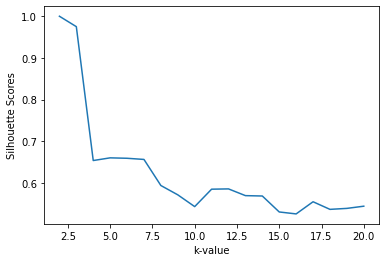

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(df_final["k"], df_final["Silhouette"])
plt.ylabel("Silhouette Scores")
plt.xlabel("k-value")
plt.show()